In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
df = pd.read_csv('./build-7-5-2024.csv')

In [ ]:
known_templates = ['Devops-New', 'Devops-LegoBricks', 'Carrier.Pipeline.Templates*', 'Online.Azure.Pipeline.Library*', 'DataScience.Pipeline.Library', 'Rating.SharedDeploy*', 'CloudPlatform.Azure.Pipeline.Library', 'dbt-cli-pipeline-template', 'Vision.Azure.Pipeline.Library*', 'EDP.Snowflake.Pipeline.Library*', 'CHR.ADO.Test.Pipeline.Template**', 'dds.ado.library*', 'AzureML.Pipeline.Library', 'CloudTechnologies.ADO.Library']

In [ ]:
category_list = []

def check_pr(pr):
    for entry in pr:
        if 'development' in entry:
            category = 'CD_DeployToDev'
        elif 'main' in entry:
            category = 'CD_DeployToProd'
        elif 'master' in entry:
            category = 'CD_DeployToProd'
        else:
            category = 'investigate'
            
        category_list.append(category)

    return category_list

In [ ]:
df['PR_Process'] = check_pr(df['Branch'])
df = df.rename(columns={'Build Reason': 'BuildReason'})

In [ ]:
pr_type_list = []

def combine_pr_data(dframe):
    
    for row in dframe.itertuples():
        
        if row.BuildReason == 'individualCI' or row.BuildReason == 'manual':
            pr_types = 'CI_' + row.PR_Process
        elif row.BuildReason == 'pullRequest':
            pr_types = 'CI_PR'
        else:
            pr_types = row.BuildReason
                            
        pr_type_list.append(pr_types)


    return pr_type_list

In [ ]:
df['PR_Process_Type'] = combine_pr_data(df)

In [ ]:
from ast import literal_eval
df['Templates'] = (df['Templates'].replace(r"' '", r"', '", regex=True).apply(literal_eval))
df['Error Codes'] = (df['Error Codes'].replace(r"' '", r"', '", regex=True).apply(literal_eval))
df['Failed Tasks'] = (df['Failed Tasks'].replace(r"' '", r"', '", regex=True).apply(literal_eval))

In [ ]:
def get_template_type(template_list):
    for temps in template_list:
        if len(temps)==0:
            template_type = ''
        elif len(temps)==1:
            # Determine what type
            if temps[0] == 'devops-azure-pipeline-templates':
                template_type = 'Devops-New'
            elif temps[0] == 'DevOps.Azure.Pipeline.Library':
                template_type = 'Devops-LegoBricks'
            else:
                template_type = temps[0]
        else:
            # Handle multiple templates case
            if 'DevOps.Azure.Pipeline.Library' in temps:
                temps.remove('DevOps.Azure.Pipeline.Library')
                template_type = temps[0] + '*'
            else:
                template_type = temps[0] + '**'

        template_type_list.append(template_type)

    return template_type_list

In [ ]:
template_type_list = []

df['TemplateType'] = get_template_type(df['Templates'])

In [ ]:
df['KnownTemplates'] = df['TemplateType'].apply(lambda x: True if x in known_templates else False)
df_known = df['KnownTemplates'].value_counts().reset_index()

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=df_known['KnownTemplates'],
        values=df_known['count'],
        texttemplate="%{label}<br>"
                     "%{percent:.1%} (%{value})",
        showlegend=False,
        # Add bolded labels for each piece of data
        hovertemplate="<b>Status</b>: %{label}<br>"
                      "<b>Count</b>: %{value:.2f}<br>"
                      "<b>% of total status count</b>: %{percent:.2%}<br>"
                      "<extra></extra>",
        pull=[0.03, 0, 0],
    )
)
fig.update_traces(
    # Size of the hole in the middle [0-1]
    hole=0.3
)
fig.update_layout(
    # Add annotations in the centre of the donut.
     width=600, height=600,
    annotations=[
        dict(
            text='<b>Builds using <br>templates</b>', 
            x=0.5, y=0.5, 
            font_size=12,
            showarrow=False
        ),
    ],
    # Title text. Other properties are available.
    title=dict(
        text="<b>Builds using templates or not<b>"
    )
)
fig.show()

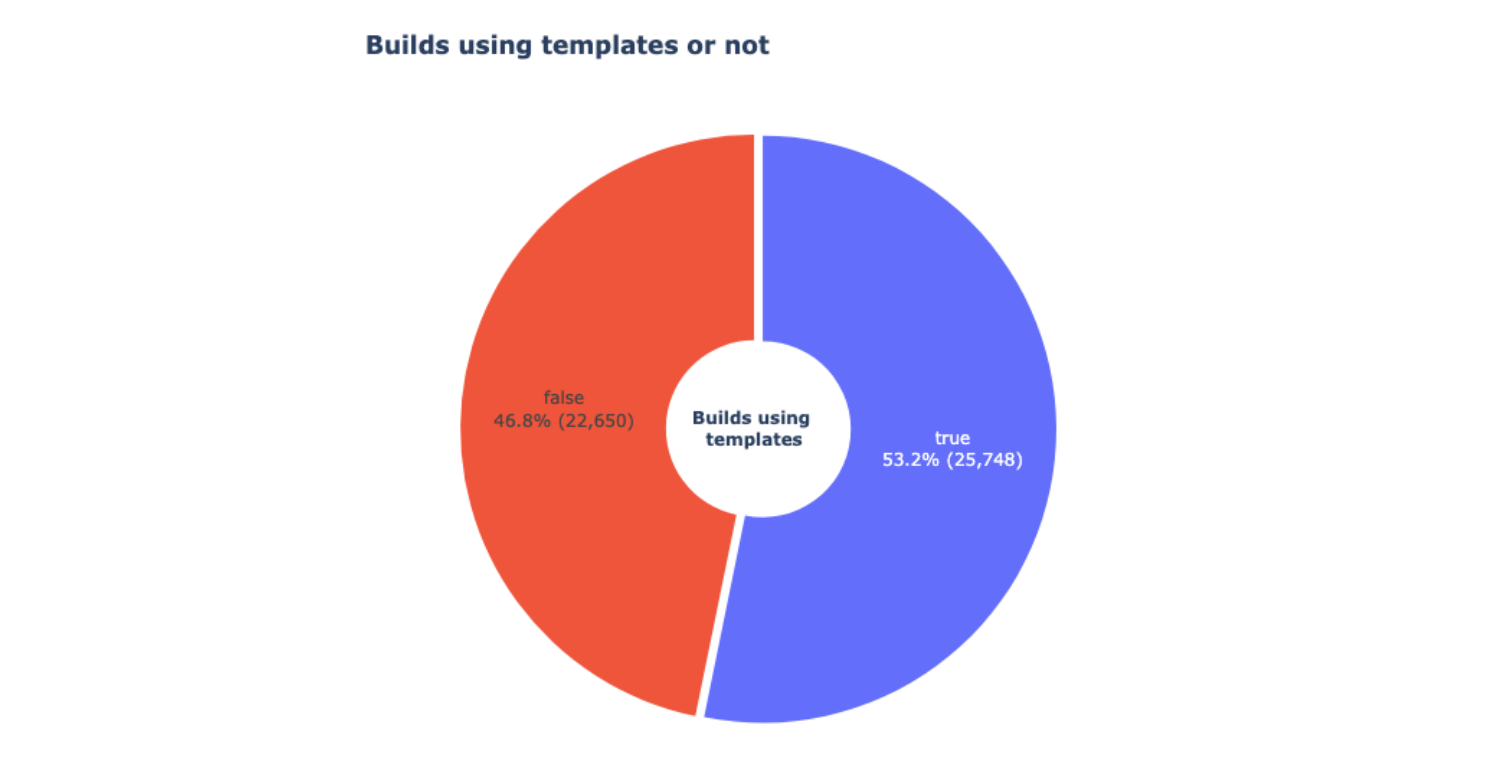

In [ ]:
df = df[df['KnownTemplates']==True]

In [ ]:
df_templates_group_tt = df['TemplateType'].value_counts().reset_index()

fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=df_templates_group_tt['TemplateType'],
        values=df_templates_group_tt['count'],
        texttemplate="%{label}<br>"
                     "%{percent:.1%} (%{value})",
        showlegend=False,
        # Add bolded labels for each piece of data
        hovertemplate="<b>Status</b>: %{label}<br>"
                      "<b>Count</b>: %{value:.2f}<br>"
                      "<b>% of total status count</b>: %{percent:.2%}<br>"
                      "<extra></extra>",
        pull=[0.03, 0, 0],
    )
)
fig.update_traces(
    # Size of the hole in the middle [0-1]
    hole=0.5
)
fig.update_layout(
    # Add annotations in the centre of the donut.
     width=600, height=600,
    annotations=[
        dict(
            text='<b>Template<br>usage</b>', 
            x=0.5, y=0.5, 
            font_size=12,
            showarrow=False
        ),
    ],
    # Title text. Other properties are available.
    title=dict(
        text="<b>Template usage by build data<b>"
    )
)
fig.show()


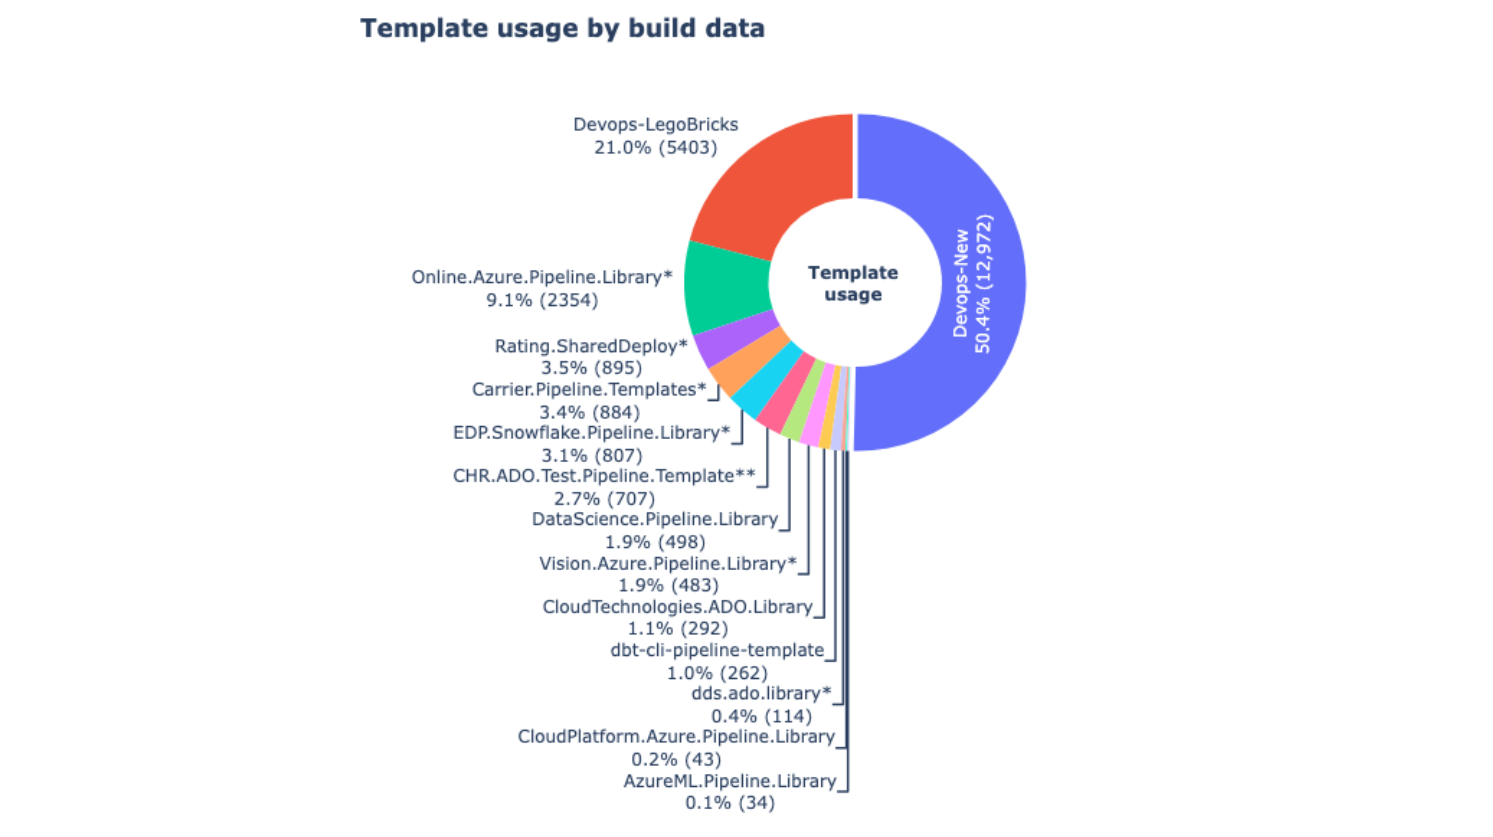

In [ ]:
# One-hot encoding on Result column
df = pd.get_dummies(df, columns=['Result'])

In [ ]:
df_group = (
    df.groupby(["TemplateType","PR_Process_Type"])
    .agg(
        builds=pd.NamedAgg("Build Id", "count"),
        successes=pd.NamedAgg("Result_succeeded", "sum"),
        failures=pd.NamedAgg("Result_failed", "sum"),
        # canceled=pd.NamedAgg("Result_canceled", "sum"),
        # partial_success=pd.NamedAgg("Result_partiallySucceeded", "sum"),
        # mean_queue_time=pd.NamedAgg("QueueSeconds", "mean"),
        # mean_build_time=pd.NamedAgg("BuildSeconds", "mean"),
        # mean_queueBuild_time = pd.NamedAgg("QueueBuildSeconds", "mean")
    )
    .reset_index(drop=False)
    .round(1)
)

df_group['success_rate'] = ((df_group['successes'])/(df_group['successes'] + df_group['failures']))

df_group.sort_values(by=["TemplateType"], inplace=True, ascending=False)

df_group

In [ ]:
relevant_types = ['CI_CD_DeployToProd', 'CI_CD_DeployToDev', 'CI_PR']
df_group['Relevant'] = df_group['PR_Process_Type'].apply(lambda x: True if x in relevant_types else False)
df_group_relevant = df_group[df_group['Relevant'] == True]
df_group_relevant

In [ ]:
fig = go.Figure()

colors = {'CI_CD_DeployToProd': 'lightblue', 'CI_CD_DeployToDev': 'lightslategrey','CI_PR': 'seagreen'}

for t in df_group_relevant['PR_Process_Type'].unique():
    dfp = df_group_relevant[df_group_relevant['PR_Process_Type']==t]
    fig.add_traces(go.Bar(x=dfp['TemplateType'], y = dfp['success_rate'], name=t,
                         marker_color=colors[t], text=dfp["success_rate"],
                        textposition="outside",
                        texttemplate="%{text:.1%}"))

fig.update_layout(
    width=1200, height=600,
    title='Success rate across template types',
    plot_bgcolor="white",
    xaxis=dict(showticklabels=True),
    yaxis=dict(showticklabels=True),
    # barmode="stack",
)

fig.layout.yaxis.tickformat = ',.0%'

fig.update_xaxes(tickangle=45)

fig.show()

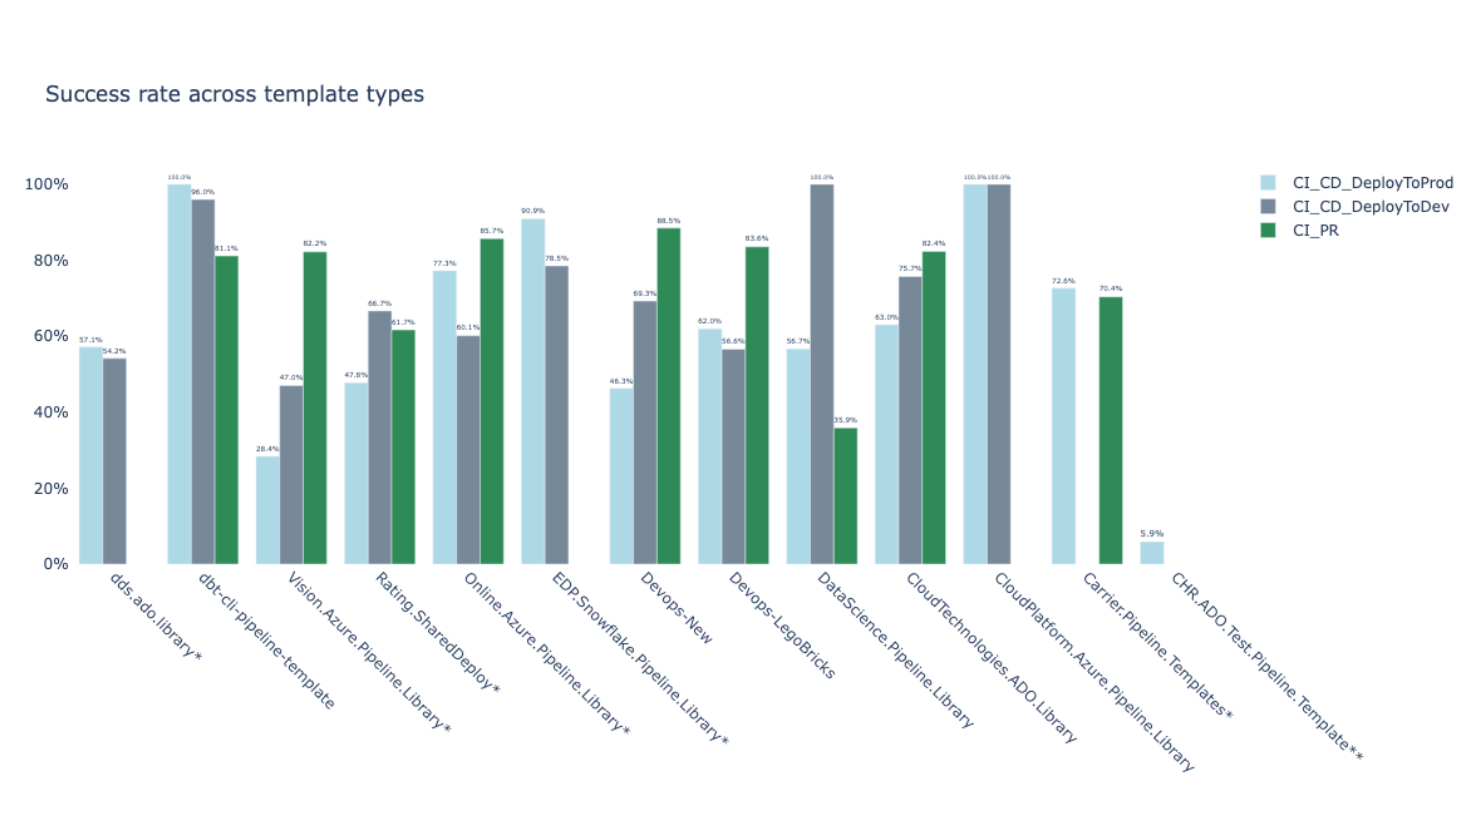

In [ ]:
custom_dict = {'CI_PR': 0, 'CI_CD_DeployToDev': 1, 'CI_CD_DeployToProd': 2} 
df_group_relevant = df_group_relevant[df_group_relevant['TemplateType']=='Devops-New']
df_group_relevant = df_group_relevant.sort_values(by=['PR_Process_Type'], key=lambda x: x.map(custom_dict))
df_group_relevant

In [ ]:
fig = go.Figure()

colors = {'CI_CD_DeployToProd': 'lightblue', 'CI_CD_DeployToDev': 'lightslategrey','CI_PR': 'lemonchiffon'}

for t in df_group_relevant['PR_Process_Type'].unique():
    dfp = df_group_relevant[df_group_relevant['PR_Process_Type']==t]
    fig.add_traces(go.Bar(x=dfp['TemplateType'], y = dfp['builds'], name=t,
                         marker_color=colors[t], text=dfp["builds"],
                        textposition="outside",))
                        # texttemplate="%{text:.1%}"))

fig.update_layout(
    width=600, height=600,
    title='Build count across build types',
    plot_bgcolor="white",
    xaxis=dict(showticklabels=True),
    yaxis=dict(showticklabels=True),
    # barmode="stack",
)

fig.update_xaxes(tickangle=45)

fig.show()

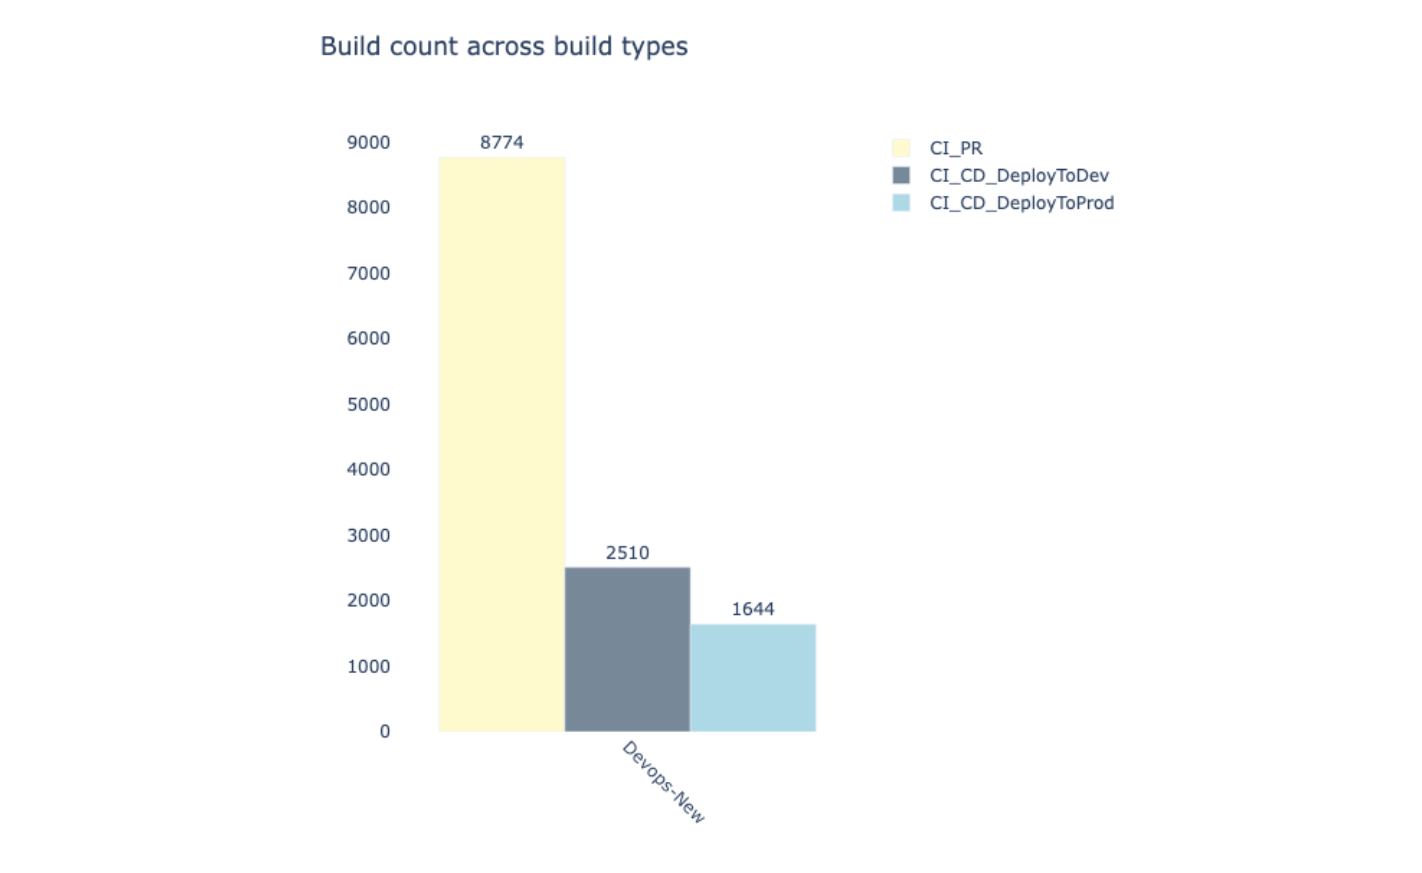

In [ ]:
fig = go.Figure()

colors = {'CI_CD_DeployToProd': 'lightblue', 'CI_CD_DeployToDev': 'lightslategrey','CI_PR': 'lemonchiffon'}

for t in df_group_relevant['PR_Process_Type'].unique():
    dfp = df_group_relevant[df_group_relevant['PR_Process_Type']==t]
    fig.add_traces(go.Bar(x=dfp['TemplateType'], y = dfp['success_rate'], name=t,
                         marker_color=colors[t], text=dfp["success_rate"],
                        textposition="outside",
                        texttemplate="%{text:.1%}"))

fig.update_layout(
    width=600, height=600,
    title='Success rate across build types',
    plot_bgcolor="white",
    xaxis=dict(showticklabels=True),
    yaxis=dict(showticklabels=True),
    # barmode="stack",
)

fig.layout.yaxis.tickformat = ',.0%'

fig.update_xaxes(tickangle=45)

fig.show()

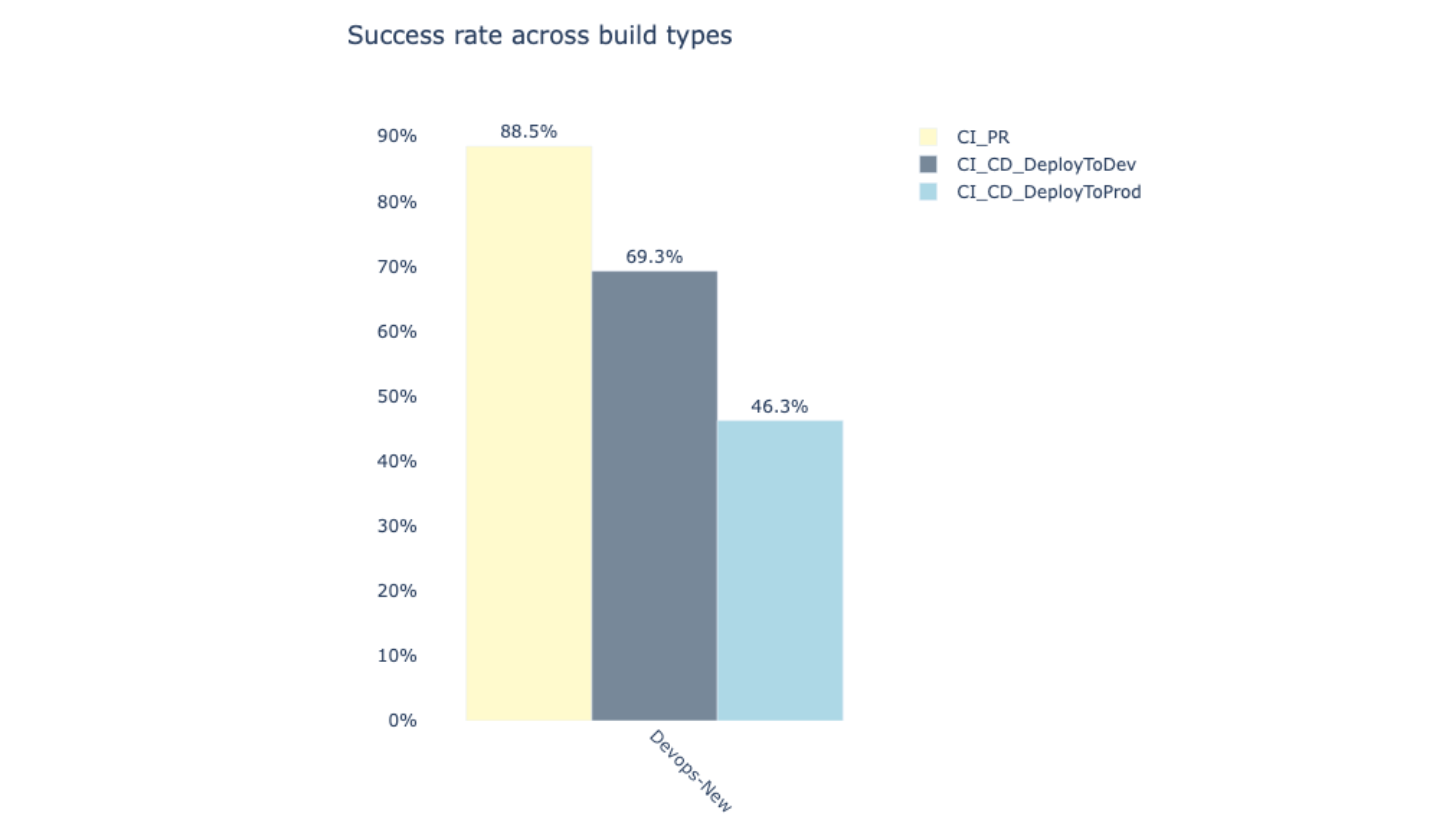

In [ ]:
df_new_status = df[df['TemplateType']=='Devops-New']
df_status = df_new_status['Result_failed'].value_counts().reset_index()
df_status

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=df_status['Result_failed'],
        values=df_status['count'],
        texttemplate="%{percent:.1%} (%{value})",
        showlegend=False,
        # Add bolded labels for each piece of data
        hovertemplate="<b>Position</b>: %{label}<br>"
                      "<b>Status</b>: %{value:.2f}<br>"
                      "<b>% of total status</b>: %{percent:.2%}<br>"
                      "<extra></extra>",
        pull=[0.03, 0, 0],
    )
)
fig.update_traces(
    # Size of the hole in the middle [0-1]
    hole=0.3
)
fig.update_layout(
    # Add annotations in the centre of the donut.
     width=600, height=600,
    annotations=[
        dict(
            text='<b>Success rate <br>for<br>new templates</b>', 
            x=0.5, y=0.5, 
            font_size=12,
            showarrow=False
        ),
    ],
    # Title text. Other properties are available.
    title=dict(
        text="<b>New template success rate<b>"
    )
)
fig.show()

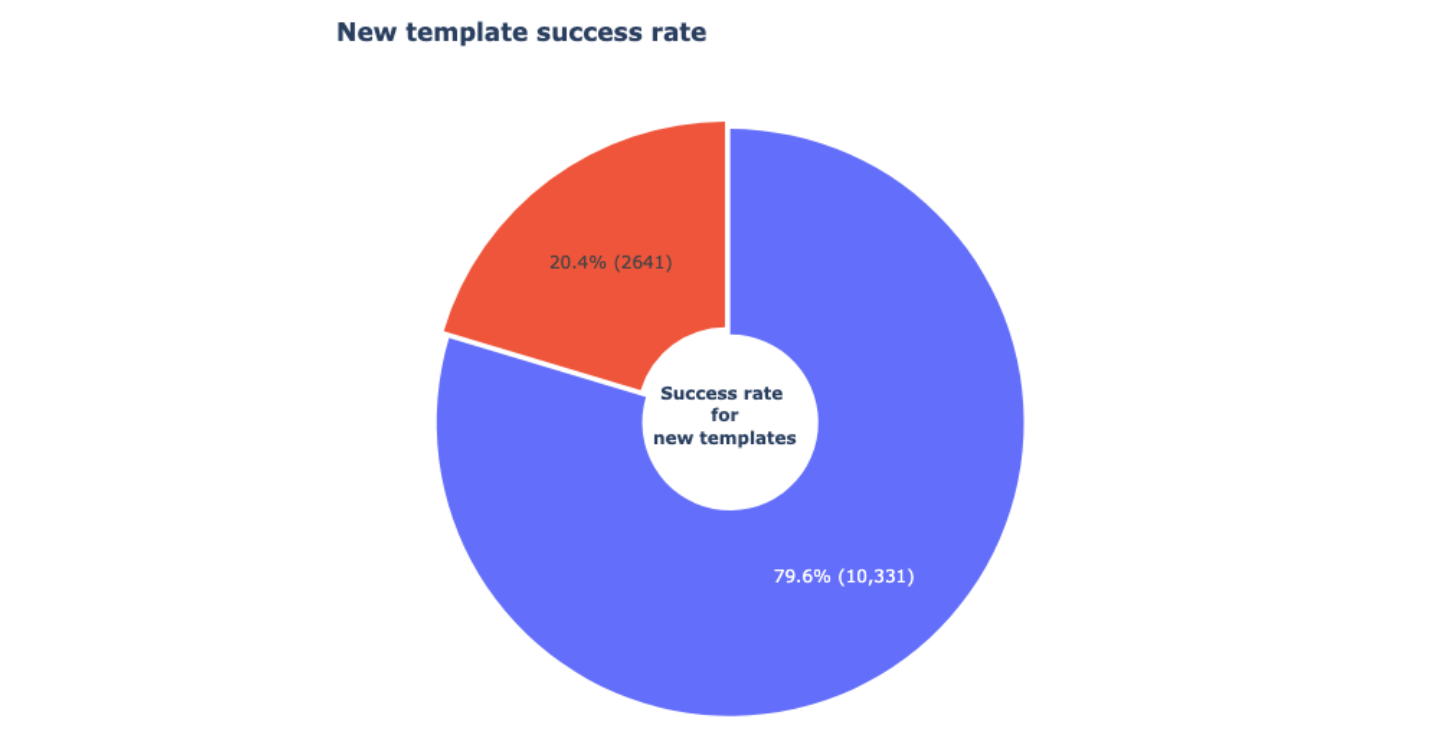

# Error reporting

In [ ]:
dpc_aat = ['dpc_dotnet_aat', 'dpc_npm_e2e', 'dpc_create_file_error']
dpc_unit = ['dpc_dotnet_test', 'dpc_npm_test', 'dpc_python_run_tests_error']
dpc_build = ['dpc_npm_build', 'dpc_dotnet_build', 'dpc_docker_build', 'dpc_dotnet_restore', 'dpc_prisma_version_error', 'dpc_prisma_install_error', 'dpc_dotnet_sonarscanner', 'dpc_python_linting_error']
dpc_database = ['dpc_dacpac_publish_error']
dpc_deployment = ['dpc_helm_upgrade', 'dpc_helm_uninstall', 'dpc_helm_values_upgrade']
dpc_helm = ['dpc_helm_dry_run_pending_install', 'dpc_helm_template_validation', 'dpc_validation_deployment_label_error']     
dpc_post_production_deploy = ['dpc_rfc_creation_error']

In [ ]:
df_error = df[(df['Result_failed']==True) & (df['TemplateType'] == 'Devops-New')]

df_error['Relevant'] = df_error['PR_Process_Type'].apply(lambda x: True if x in relevant_types else False)
df_error = df_error[df_error['Relevant'] == True]

custom_dict = {'CI_PR': 0, 'CI_CD_DeployToDev': 1, 'CI_CD_DeployToProd': 2} 

In [ ]:
df_error['Start Date'] = df_error['Start Time'].apply(lambda x: pd.to_datetime(x.split('T')[0]))
df_error['Week'] = df_error['Start Date'].dt.to_period('W')
df_error['Code'] = df_error['Error Codes'].apply(lambda x: x[0] if len(x) > 0 else x)

In [ ]:
cli_list = []

def get_cli_error_category(cli_errors):
    
    for error in cli_errors:
        code = str(error).strip()
        if code in dpc_aat:
            cat = 'AAT'
        elif code in dpc_unit:
            cat = 'Unit test'
        elif code in dpc_build:
            cat = 'Build'
        elif code in dpc_database:
            cat = 'Database'
        elif code in dpc_deployment:
            cat = 'Helm deployment'
        elif code in dpc_helm:
            cat = 'Helm checks'
        elif code in dpc_post_production_deploy:
            cat = 'Post-prod deploy'   
        else:
            cat = 'Uncategorised'
        
        cli_list.append(cat)

    return cli_list

In [ ]:
df_error['CliCategory'] = get_cli_error_category(df_error['Code'])
df_error['FailedTask'] = df_error['Failed Tasks'].apply(lambda x: x[0] if len(x) > 0 else x)
df_uncat = df_error[df_error['CliCategory']=='Uncategorised']

df_devops_errors = df_error['CliCategory'].value_counts().reset_index()
df_devops_errors

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=df_devops_errors['CliCategory'],
        values=df_devops_errors['count'],
        texttemplate="%{label}<br>"
                     "%{percent:.1%} (%{value})",
        showlegend=False,
        # Add bolded labels for each piece of data
        hovertemplate="<b>Position</b>: %{label}<br>"
                      "<b>Status</b>: %{value:.2f}<br>"
                      "<b>% of total status</b>: %{percent:.2%}<br>"
                      "<extra></extra>",
        pull=[0.03, 0, 0],
    )
)
fig.update_traces(
    # Size of the hole in the middle [0-1]
    hole=0.3
)
fig.update_layout(
    # Add annotations in the centre of the donut.
     width=600, height=600,
    annotations=[
        dict(
            text='<b>Failure<br>categories</b>', 
            x=0.5, y=0.5, 
            font_size=12,
            showarrow=False
        ),
    ],
    # Title text. Other properties are available.
    title=dict(
        text="<b>Failure categories for new templates<b>"
    )
)
fig.show()

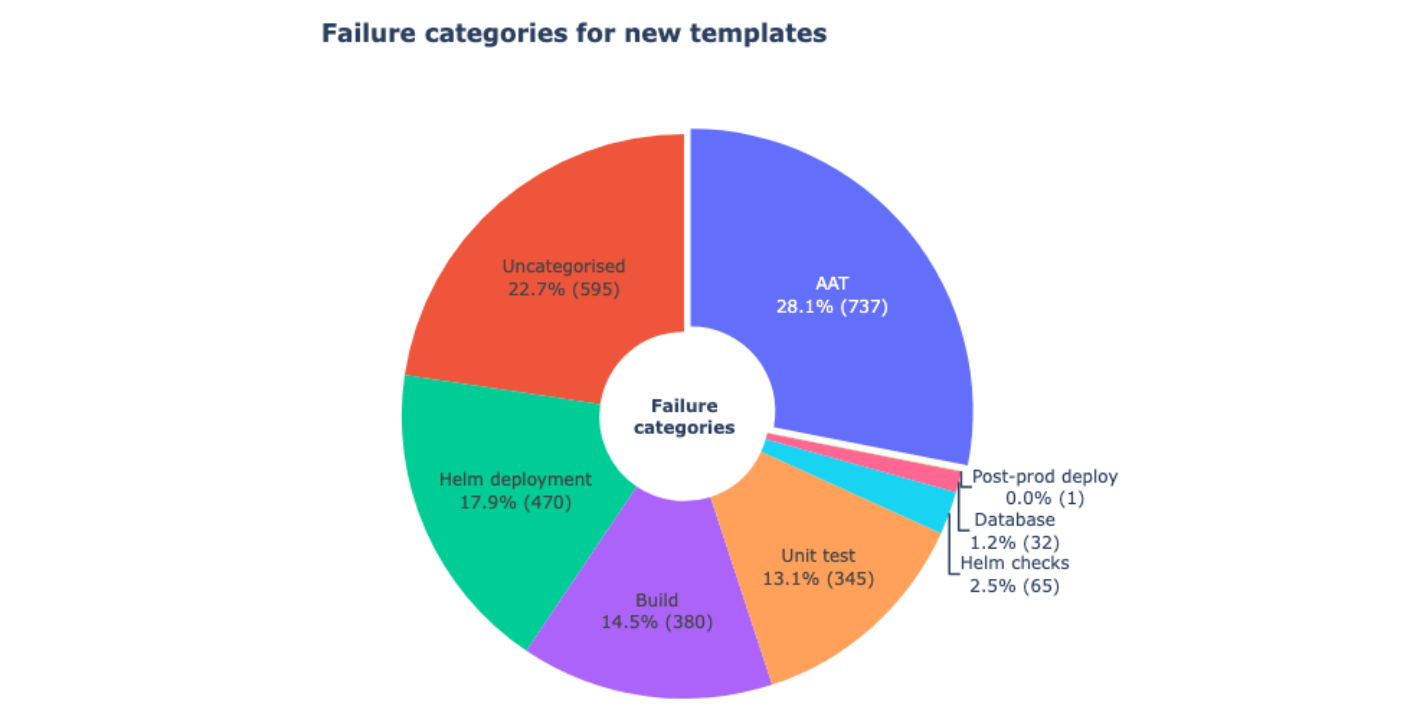

In [ ]:
df_new_grouped = df_error.groupby(['PR_Process_Type','CliCategory']).agg(Count=pd.NamedAgg('Build Id', 'count')).reset_index()

df_new_grouped = df_new_grouped.sort_values(by=['PR_Process_Type'], key=lambda x: x.map(custom_dict))

In [ ]:
fig = go.Figure()

colors = {'AAT': 'lightblue', 'Build': 'lightslategrey','Helm checks': 'seagreen', 'Helm deployment': 'violet', 'Uncategorised': 'sandybrown', 'Unit test': 'lemonchiffon', 'Post-prod deploy': 'olive', 'Database': 'seashell',}

for t in df_new_grouped['CliCategory'].unique():
    dfp = df_new_grouped[df_new_grouped['CliCategory']==t]
    fig.add_traces(go.Bar(x=dfp['PR_Process_Type'], y = dfp['Count'], name=t,
                         marker_color=colors[t], text=dfp["Count"],
                        textposition="outside",))
                        # texttemplate="{text}"))

fig.update_layout(
    width=900, height=600,
    title='Failures by build type',
    plot_bgcolor="white",
    xaxis=dict(showticklabels=True),
    yaxis=dict(showticklabels=True),
    # barmode="stack",
)

fig.update_xaxes(tickangle=45)

fig.show()

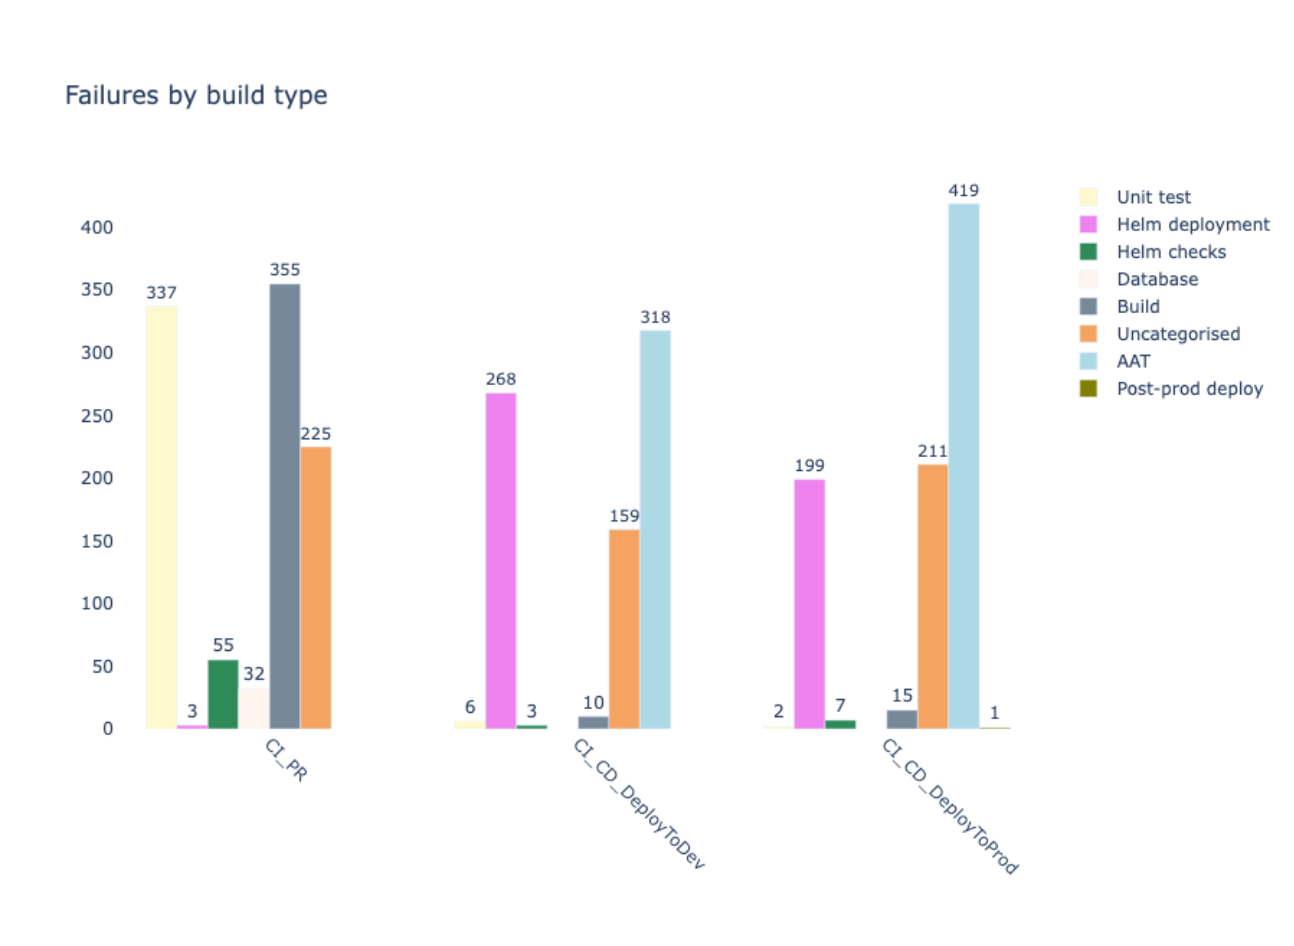

# Time series error categorisation

In [ ]:
df_error_group = (
    df_error.groupby(["Week", "CliCategory"])
    .agg(
        count=pd.NamedAgg("Build Id", "count"),
    )
    .reset_index(drop=False)
    .round(1)
)

df_error_group.sort_values(by=["Week", "CliCategory"], inplace=True, ascending=True)

df_error_group["Week"] = df_error_group["Week"].astype('str')

df_error_group

In [ ]:
fig = px.line(df_error_group, x='Week', y='count', color='CliCategory', markers=True)
fig.update_layout(width=900, height=600,)
fig.show()

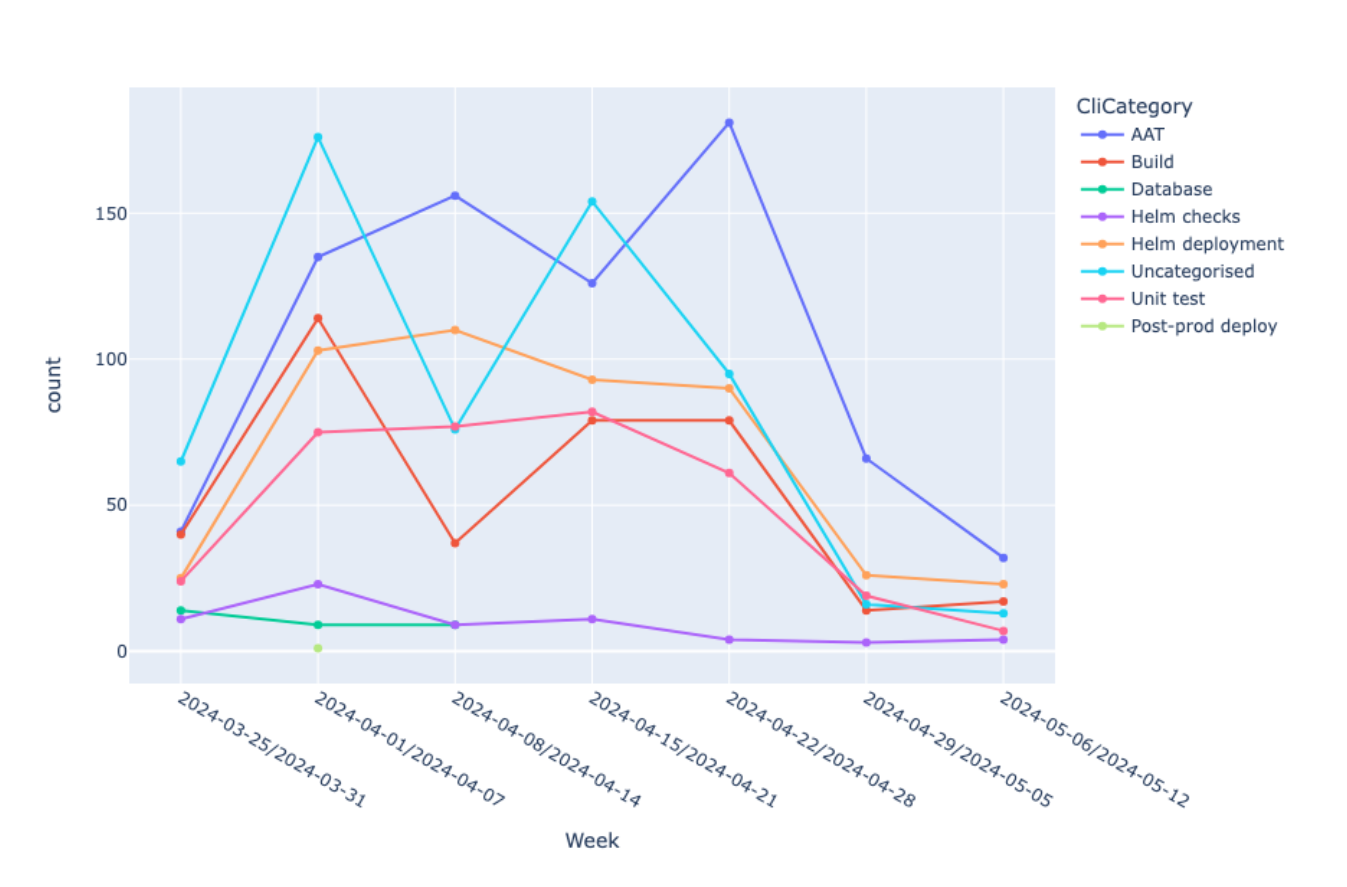